# Projet 7 : Implémentez un modèle de scoring

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# pré-processing
import kernel_preprocess
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# mesure de la performance
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import time

# modèles testés
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import lightgbm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap

import joblib

Import des données nécessaires grâce au script 'kernel_preprocess.py'

In [3]:
data, interestData, descriptions = kernel_preprocess.build_dataFrames()

Nous séparons les variables prédictrices de celle que nous cherchons à prédire.

In [4]:
X = data.loc[:,data.columns !='TARGET']

In [5]:
Y = data['TARGET']

Nous écrivons les données sur disque pour le déploiement.

In [1]:
data.to_csv('processedData.csv')
descriptions.to_csv("descriptions.csv")

In [7]:
data.sample(50000).to_csv('sampleData.csv')

Nous construisons ensuite un set d'entrainement, de test et de validation.

In [5]:
# Nous utilisons une grande proportion de données dans les sets de test et validation car
# Les ressources mémoires disponibles ne permettent pas plus de données d'entrainement
X_train, X_validation, y_train, y_validation = train_test_split(X, Y,
                                                                stratify=Y, 
                                                                test_size=0.5)

X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation,
                                                              stratify=y_validation, 
                                                              test_size=0.5)

Une difficulté majeure pour l'entrainement de notre modèle tient dans l'inégalité des classes à prédire.

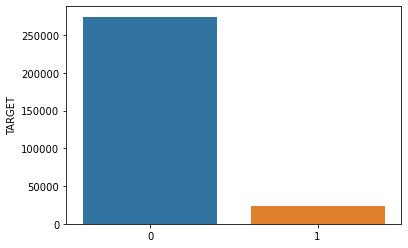

In [6]:
sns.barplot(x=[0,1],
            y= Y.value_counts());

Nous utilisons le score f-beta avec beta = 2 qui est adapté à notre problème (cf note méthodologique)

In [7]:
f_beta_2 = make_scorer(fbeta_score,beta=2)
scoring = {'f_beta':f_beta_2,'recall':'recall'}

Nous allons tester plusieurs combinaisons de modèles et de pré-traitements afin de déterminer la meilleure façon d'aborder ce problème.

In [8]:
def test_model(X,y,model,modelName):
    
    
    
    under = RandomUnderSampler(sampling_strategy=0.5)
    over = SMOTE(n_jobs=-1)
    
    
    simple = [('model', model)]
    underPlusOverSample = [('under',under),('over',over),('model', model)]
    underSample = [('under',under),('model', model)]
    overSample = [('over',over),('model', model)]
    
    preprocessings = [simple,
                     underSample, 
                     overSample,
                     underPlusOverSample]
    
    class_weights = [{0:1,1:1},
                     'balanced']
    
    preprocessType = ['Simple',
                      'undersampling',
                      'oversampling',
                      'undersampling + oversampling',
                      'classWeight + Simple',
                      'classWeight + undersampling',
                      'classWeight + oversampling',
                      'classWeight + undersampling + oversampling']
    f_beta = []
    recall = []
    for weight in class_weights:
        model.class_weights = weight
        for preprocessing in preprocessings:
            pipeline = Pipeline(steps=preprocessing)
            # evaluate pipeline
            cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
            
            metrics = cross_validate(pipeline, X.values, y, scoring=scoring, cv=cv, n_jobs=-1)
            metrics = (pd.DataFrame(metrics).loc[:,['test_f_beta','test_recall']]).mean(axis=0)
            
            f_beta.append(metrics[0])
            recall.append(metrics[1])
    
    return pd.DataFrame({modelName: f_beta},index=preprocessType), pd.DataFrame({modelName: recall},index=preprocessType)

In [9]:
dummy = DummyClassifier()
logit = LogisticRegression(n_jobs=-1, 
                           solver='saga') 
rdmforest = RandomForestClassifier(n_jobs=-1)
gbm  = lightgbm.LGBMClassifier(n_jobs=-1)

In [10]:
models = [dummy,
          logit,
          rdmforest,
          gbm]
modelNames = ['Dummy Classifier',
              'Logistic Regression',
              'Random Forest',
              'Light GBM']

In [11]:
perfDataFrames = [test_model(X_train,y_train,model, modelName) for model, modelName in zip(models, modelNames)]

/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

In [12]:
f_betas = []
recalls = []
for model in perfDataFrames:
    f_betas.append(model[0])
    recalls.append(model[1])

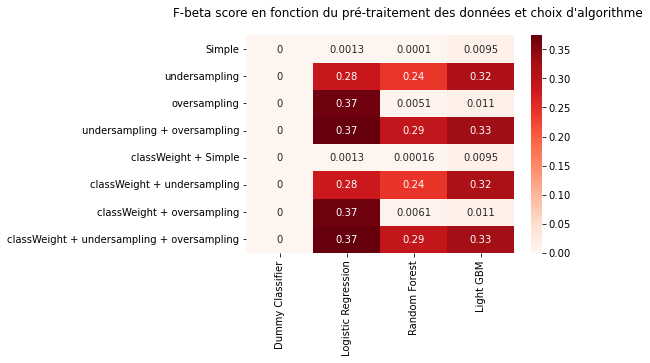

In [13]:
sns.heatmap(pd.concat(f_betas,axis=1),
            cmap='Reds',
            annot=True);
plt.suptitle("F-beta score en fonction du pré-traitement des données et choix d'algorithme");

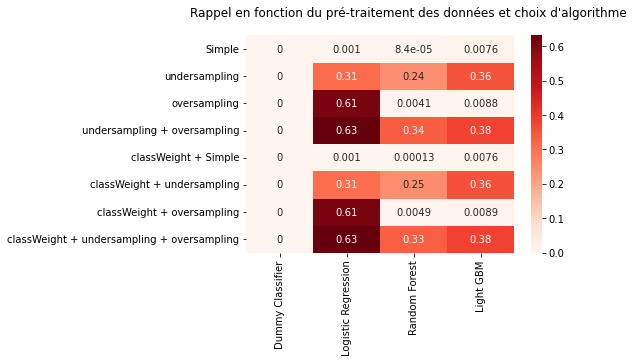

In [14]:
sns.heatmap(pd.concat(recalls,axis=1),
            cmap='Reds',
            annot=True)
plt.suptitle("Rappel en fonction du pré-traitement des données et choix d'algorithme");

La regression logistique semble être le meilleur modèle pour ce prolbème. 
- en ce qui concerne le pré-traitement nous allons utiliser l'undersampling + oversampling sans class weight
    - l'oversampling seul est légèrement meilleur sur le f-beta score mais rajouter l'undersampling nous donne de meilleures performances en rappel

#### Hyperparameter tuning

In [15]:
under = RandomUnderSampler(sampling_strategy=0.5)
over = SMOTE(n_jobs=-1)

In [16]:
x, y = under.fit_resample(X_train,y_train)

In [17]:
x, y = over.fit_resample(x,y)

In [18]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

In [20]:
recall = []
f_beta_score = []
solverParams = []
Cparams = []
counter= 0
for solver in solvers:
    logitModel = LogisticRegression(solver=solver,
                                    max_iter=4000,
                                    n_jobs=-1)
    logitModel.fit(x,y)
    recall.append(recall_score(y_test,logitModel.predict(X_test)))
    f_beta_score.append(fbeta_score(y_test,logitModel.predict(X_test),beta=2))
    solverParams.append(solver)
    counter+=1
    print(counter)
results = pd.DataFrame({'recall':recall,
                        'f_beta':f_beta_score,
                        'solver':solverParams})      
        

1
2


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.


3


The max_iter was reached which means the coef_ did not converge


4
5


In [21]:
results

,recall,f_beta,solver
0,0.623091,0.371011,newton-cg
1,0.622923,0.370933,lbfgs
2,0.622923,0.370933,liblinear
3,0.623259,0.370459,sag
4,0.620238,0.368216,saga


In [91]:
logitModel = LogisticRegression(solver='saga',
                                n_jobs=-1,
                                max_iter=4000)

In [92]:
logitModel.fit(x.values,y)

LogisticRegression(max_iter=4000, n_jobs=-1, solver='saga')

### Performance sur le jeu de test

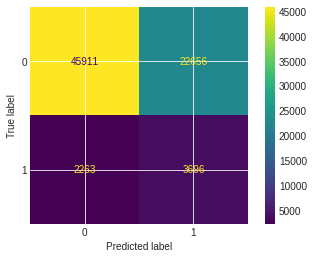

In [93]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,logitModel.predict(X_test.values)))
disp.plot();

In [25]:
fbeta_score(y_test,logitModel.predict(X_test.values),beta=2)

0.3682155096835897

In [26]:
recall_score(y_test,logitModel.predict(X_test.values))

0.6202382950159423

### Performance sur le jeu de validation

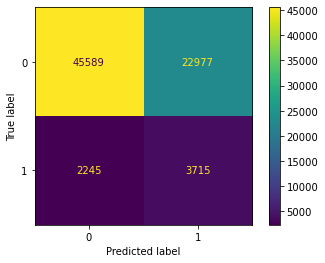

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_validation,logitModel.predict(X_validation.values)))
disp.plot();

In [94]:
fbeta_score(y_validation,logitModel.predict(X_validation.values),beta=2)

0.36758885458719226

In [95]:
recall_score(y_validation,logitModel.predict(X_validation.values))

0.6233221476510067

Nous sauvegardons notre modèle.

In [96]:
joblib.dump(logitModel,"logitModel.pkl")

['logitModel.pkl']

## Optimisation du seuil d'acceptation
- Nous allons ajouter une dimension métier à notre modèle : 
    

Plutôt que considérer qu'un risque de défaut de paiement supérieur à 50% = un refus, nous allons tenter de définir ce seuil empiriquement sur la base des gains de l'entreprise.

On récupère seulement la probabilité qu'un client ne rembourse pas son prêt

In [98]:
probas = logitModel.predict_proba(X.values)

In [99]:
defaultProba = [proba[1] for proba in probas]

On construit alors un dataset réunissant les probabilités de défaut et le comportement réel des clients

In [100]:
calibrationDataset = pd.DataFrame({'truth':Y.values,
                                   'defaultProba':defaultProba},
                                    index=Y.index)

In [101]:
calibrationDataset

,truth,defaultProba
SK_ID_CURR,,
100002,1.0,0.880778
100003,0.0,0.137901
100004,0.0,0.328224
100007,0.0,0.603759
100008,0.0,0.545636
...,...,...
456251,0.0,0.413684
456252,0.0,0.667187
456253,0.0,0.342980


Nous allons joindre ce dataset avec celui des intérets

In [102]:
interestData

,RATE_INTEREST_PRIMARY,AMT_CREDIT,TARGET,gain
SK_ID_CURR,,,,
271877,0.182832,533668.5,0.0,97571.574188
170289,0.196914,225000.0,0.0,44305.720843
250662,0.189136,180000.0,0.0,34044.542673
414811,0.695668,240660.0,0.0,167419.358211
332996,0.191757,182286.0,0.0,34954.678256
...,...,...,...,...
258580,0.179687,630000.0,0.0,113202.567154
375705,0.193330,675000.0,0.0,130497.704862
446465,0.182818,180000.0,0.0,32907.174430


Malheuresement la colonne 'RATE_INTEREST_PRIMARY' contenant le pourcentage d'intérêt que la banque gagne sur un prêt n'est pas très fournie. 
- Elle compte tout de même + de 4000 points de données.

De plus, la distribution des crédits remboursés et en défaut est fidèle au reste du dataset.

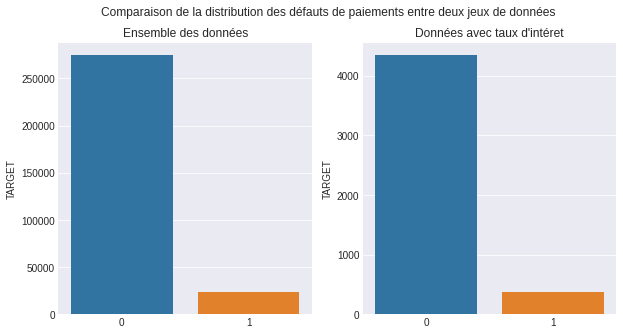

In [103]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.barplot(x=[0,1],
            y= Y.value_counts(),
            ax=ax[0])
ax[0].set_title('Ensemble des données')
sns.barplot(x=[0,1],
            y= interestData['TARGET'].value_counts(),
            ax=ax[1]);
ax[1].set_title("Données avec taux d'intéret")
plt.suptitle('Comparaison de la distribution des défauts de paiements entre deux jeux de données');

Nous multiplions le montant du prêt par le taux d'intérêt pour obtenir le montant récupéré par la banque

In [104]:
interestData['gain'] = interestData['AMT_CREDIT'] * interestData['RATE_INTEREST_PRIMARY']

In [105]:
gainEstimatorData = (interestData.join(calibrationDataset,how='inner')).drop('TARGET',axis=1)

In [106]:
gainEstimatorData

,RATE_INTEREST_PRIMARY,AMT_CREDIT,gain,truth,defaultProba
SK_ID_CURR,,,,,
100069,0.189136,640458.0,121133.887283,0.0,0.734874
100070,0.160716,1227901.5,197343.797688,0.0,0.309129
100285,0.193330,180000.0,34799.387963,0.0,0.540374
100429,0.193330,629325.0,121667.360167,0.0,0.690727
100507,0.196914,450000.0,88611.441687,0.0,0.745024
...,...,...,...,...,...
455997,0.160716,819792.0,131753.944917,0.0,0.853285
456004,0.189122,405000.0,76594.483169,0.0,0.337152
456021,0.189136,405000.0,76600.221013,0.0,0.276331


Grâce à ces données nous pouvons faire varier le seuil à partir duquel on refuse un crédit et observer combien d'argent ce choix nous fait gagner.

In [107]:
def get_balance(data,threshold):
    assumed_returned = data[data['defaultProba'] < threshold]
    returned = assumed_returned[assumed_returned['truth']==0]
    default = assumed_returned[assumed_returned['truth']==1]
    lost = default['AMT_CREDIT'].sum()
    gained = returned['gain'].sum()
    return gained - lost

In [108]:
threshs = np.linspace(0,1,200)

In [109]:
balances = [get_balance(gainEstimatorData,thresh) for thresh in threshs]
bestBalance = max(balances)
optimalTreshold = threshs[balances.index(bestBalance)]

In [110]:
plt.style.use('seaborn-darkgrid')

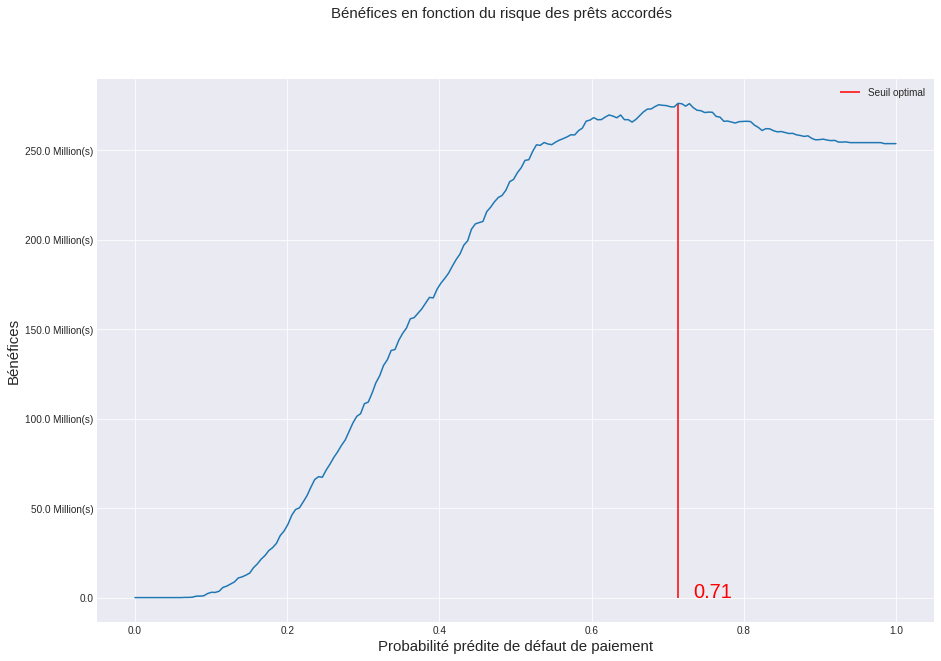

In [111]:
def readable_number(number,tick_number):
    if number < 1000000:
        return np.round(number,2)
    elif number >= 1000000 and number < 1000000000:
        str_number = str(np.round(number / 1000000,2))
        return f'{str_number} Million(s)'
    elif  number >= 1000000000:
        str_number = str(np.round(number / 1000000000,2))
        return f'{str_number} Milliard(s)'
    
fig, ax = plt.subplots(figsize=(15,10))
ax.vlines(ymax=bestBalance,
           ymin=0, 
           x=optimalTreshold,
           colors='red',
           label='Seuil optimal')
plt.text(x=optimalTreshold+0.02,
         y=0.2,
         s=np.round(optimalTreshold,2),
         fontsize=20,
        color='red')
plt.legend()
plt.plot(threshs,balances)
ax.yaxis.set_major_formatter(plt.FuncFormatter(readable_number))
plt.ylabel("Bénéfices", fontsize=15)
plt.xlabel('Probabilité prédite de défaut de paiement', fontsize=15)
plt.suptitle("Bénéfices en fonction du risque des prêts accordés", fontsize=15);

On voit ici que le seuil optimal a été déterminé à 0.71

### Interprétation des résultats
- Nous allons maintenant expliquer par valeurs shap la décision du modèle pour un cas positif et un cas négatif

In [112]:
individu_1 = 100002  # cas positif
individu_2 = 200001  # cas négatif

In [113]:
calibrationDataset.loc[individu_1,:]

truth           1.000000
defaultProba    0.880778
Name: 100002, dtype: float64

In [114]:
calibrationDataset.loc[individu_2,:]

truth           0.000000
defaultProba    0.322257
Name: 200001, dtype: float64

In [115]:
shap.initjs()

In [116]:
linearExplainer = shap.LinearExplainer(logitModel, X)

In [143]:
joblib.dump(linearExplainer,"explainer.pkl")

['explainer.pkl']

### Cas positif

In [117]:
shap.force_plot(linearExplainer.expected_value,
                linearExplainer.shap_values(X.loc[individu_1,:]),
                feature_names=X_test.columns)

In [118]:
max_display = 15

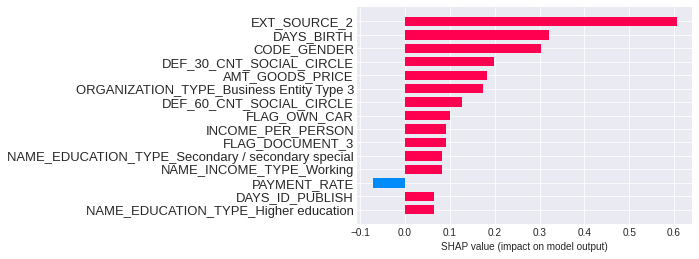

In [119]:
shap.bar_plot(linearExplainer.shap_values(X.loc[individu_1,:]),
              feature_names=X_test.columns,
              max_display=max_display)

### Cas négatif

In [120]:
shap.force_plot(linearExplainer.expected_value,
                linearExplainer.shap_values(X.loc[individu_2,:]),
                feature_names=X_test.columns)

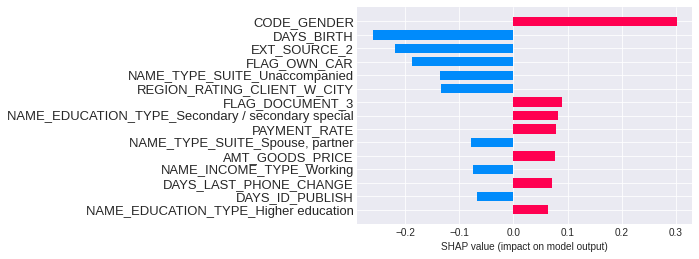

In [121]:
shap.bar_plot(linearExplainer.shap_values(X.loc[individu_2,:]),
              feature_names=X_test.columns,
              max_display=max_display)

#### Explicitation des graphiques
- Ces graphiques nous apportent des informations importantes mais ils manquent d'informations explicites 
- Que représentent ces noms de features et quelle valeur se cache derrière ces scores ? 

In [122]:
# Cette fonction nous permet d'obtenir une liste des features considérés les plus importants
def get_features(sk_id_curr):
    shapDF =  pd.DataFrame({'feature':X_test.columns,
                        'shap':linearExplainer.shap_values(X.loc[sk_id_curr,:])})
    orderedShapDF = shapDF.iloc[shapDF.shap.abs().sort_values(ascending=False).index,:]
    return orderedShapDF.head(max_display)['feature'].values

In [123]:
get_features(individu_1)

array(['EXT_SOURCE_2', 'DAYS_BIRTH', 'CODE_GENDER',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE',
       'ORGANIZATION_TYPE_Business Entity Type 3',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_OWN_CAR', 'INCOME_PER_PERSON',
       'FLAG_DOCUMENT_3',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_INCOME_TYPE_Working', 'PAYMENT_RATE', 'DAYS_ID_PUBLISH',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

Nous pouvons grâce à cette fonction expliciter le sens des features.

In [124]:
def get_description(featureName):
    info = descriptions[descriptions['Row']==featureName]['Description']
    [print(des) for des in info]

In [150]:
def get_description(featureName):
    info = descriptions[descriptions['Row']==featureName]['Description']
    return info

In [152]:
test = get_description(get_features(individu_1)[1])

In [158]:
test.values[0]

"Client's age in days at the time of application"

Et en retransformant à leur échelle originale les données nous pouvons avoir une idée de ce qui est désirable ou non.

In [126]:
scaler = joblib.load('scaler.save') 

In [127]:
unscaledData = pd.DataFrame(scaler.inverse_transform(data))
unscaledData.index = data.index
unscaledData.columns = data.columns

On voit ici que l'individu 1 est plus jeune que l'individu 2

In [128]:
unscaledData.loc[individu_1,'DAYS_BIRTH']

-9461.0

In [129]:
9461/365

25.92054794520548

In [130]:
unscaledData.loc[individu_2,'DAYS_BIRTH'] 

-21874.0

In [131]:
21874/365

59.92876712328767

Nous pouvons voir que le modèle favorise l'attribution de crédit à des personnes plus mûres.

## Positionnement de l'individu face à l'ensemble

In [132]:
defaultClientsData = unscaledData[unscaledData['TARGET']==1]
paybackClientsData = unscaledData[unscaledData['TARGET']==0]

In [159]:
defaultClientsData.to_csv('defaultClientsData.csv')
paybackClientsData.to_csv('paybackClientsData.csv')

In [133]:
def plot_feature(sk_id_curr,feature):
    plt.figure(figsize=(10,10))
    sns.kdeplot(x=feature,
                data=paybackClientsData,
                fill=True,
                label='Clients ayant remboursé')
    sns.kdeplot(x=feature,
                data=defaultClientsData,
                fill=True,
                color='red',
                alpha=0.2,
                label='Clients en défaut')
    plt.axvline(x=defaultClientsData[feature].mean(),
               color='red',
               label='Position moyenne des crédits en défaut')
    plt.axvline(x=unscaledData.loc[sk_id_curr,[feature]][0],
               color='cyan',
               label=f'Position du crédit n° {sk_id_curr}')
    plt.legend(loc='upper left')
    plt.suptitle("Comparaison entre client individuel et totalité des clients.");

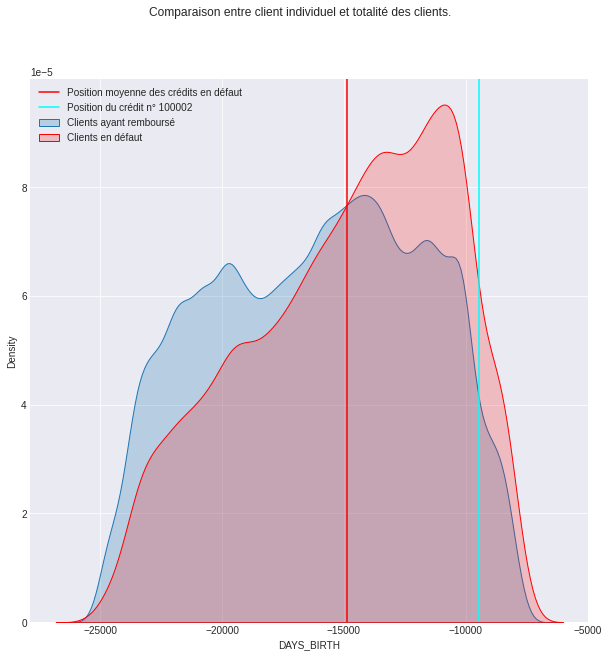

In [134]:
plot_feature(individu_1,'DAYS_BIRTH')

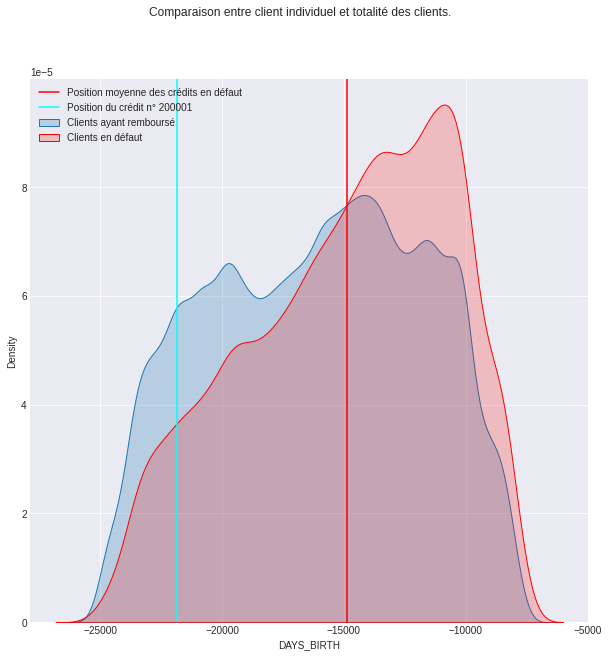

In [135]:
plot_feature(individu_2,'DAYS_BIRTH')